导入相关的包

In [217]:
import numpy as np
from matplotlib import pyplot as plt

定义计算optimal solution的函数:
$$
-\sum_{i = 1}^{n} \log (\alpha_i + x_i)
$$

In [218]:
def calculate_target(alpha,x):
    return -(np.log2(alpha+x).sum())

定义fill_water函数

在与室友的讨论之后，突然发现由于 $\sum_{i=1}^{n} \max(0,1/\nu^*-\alpha_i)$ is a piecewise-linear increasing function of $1/\nu^*$，因此对于这类问题，效率更高效果更好的一种方法无疑是进行不断二分进而快速逼近于最终的optimal $x^*$

在$fill\_water$函数中，我们首先确定一个lower与upper的初始值，因为 $x = \max(0,1/\nu - \alpha)$，因此 $\nu < 1/\alpha_i$ for all i, 故而我们选择upper的初始值为$\max(1/\alpha_i)$,而lower则是选0.

然后我们开始进行迭代，迭代其他部分与之前相同，有些不同的是更新参数的方式，与下降法更新$\nu$值不同，此处利用二分的方式更新lower或者upper，不过本质上其实也是在更新$\nu$，因为我们每一次iteration的$\nu$即是两者的均值

为了方便不同时候的需要，我们加入一个判断语句，通过可选的bool参数track, 来决定我们最后的return:
* 如果我们的输出不存在问题，可将track选为false, 以此来简化输出，仅仅输出我们最后的optimmal $x^*$
* 如果我们最后的输出不知为何出了问题，或者说我们想要看到target和error在每一步iterations之后的变化，我们可将track选为true,这样就不仅仅会输出 optimal $x^*$,还会输出数组$target[] 和 error[]$


In [219]:
def fill_water(alpha, total_water, precision, track=False):
    lower = 0
    upper = np.max(1 / alpha)
    x = np.zeros_like(alpha)
    error = 1.0
    iteration = 0
    targets = []
    errors = []
    
    while error > precision:
        nu = (lower + upper) / 2
        x = np.maximum(0, 1/nu - alpha)
        total_power = x.sum()
        error = np.abs(total_power - total_water)
        
        if track:
            targets.append(calculate_target(alpha, x))
            errors.append(error)
        
        if total_power < total_water:
            upper = nu
        else:
            lower = nu
        
        iteration += 1
        
    if track:
        return x, targets, errors
    return x

此处我们先规定随机生成的 $\alpha$ 的区间，并规定 $total_water = 1.0$ 和 $dimension = 10$，换到实际问题中便可以是我们规定总水量为1吨，总共有10个channels，
再给出我们像要达到的精确度，此处设为了$10^{-6}$

然后我们再使用random函数随机生成了10个$\alpha_i$值，并将它们打印出来

In [220]:
alpha_range = [0.0,1.0]
total_water = 1.0
dimension = 10

precision = 1e-6

alpha = np.random.uniform(low = alpha_range[0],high = alpha_range[1],size = (dimension,1))
print(alpha)

[[0.32771433]
 [0.2321897 ]
 [0.75979905]
 [0.49925842]
 [0.35521123]
 [0.50259242]
 [0.4269906 ]
 [0.75903626]
 [0.43655023]
 [0.171907  ]]


然后我们利用定义的$fill\_water$函数求出 optimal $x^*$并将其打印出来，以及将 $\sum_{i=1}^{n} x_i^*$打印出来（可以此比较其与1的差值以见是否达到要求）

同时我们求出水位 $horizontal\_ line$ 其实也即是 $1/\nu^*$,并将其打印出来

In [221]:
x = fill_water(alpha = alpha, total_water=total_water,precision=precision)
print(x)
print(x.sum())

horizontal_line = (alpha+x).min()
print(horizontal_line)

[[0.16404628]
 [0.25957092]
 [0.        ]
 [0.        ]
 [0.13654939]
 [0.        ]
 [0.06477001]
 [0.        ]
 [0.05521038]
 [0.31985361]]
1.0000005952842315
0.49176061581498987


此处定义 $visualize\_ water$函数以对该问题的最终结果进行可视化呈现:

The height of each patch is given by $\alpha_i$. The region is flooded to a level $1/\nu^*$ which uses a total quantity of water equal to one. The height of the water (shown blue) above each patch is the optimal value of $x^*$.

In [222]:
def visualize_water(alpha,x,horizontal_line):
    alpha = alpha.squeeze()
    x = x.squeeze()

    x_range = range(1,x.shape[0]+1)
    plt.xticks(x_range)
    plt.bar(x_range,alpha,color = '#ff9966',width = 1.0,edgecolor = '#ff9966')
    plt.bar(x_range,x,bottom = alpha,color = '#4db8ff',width = 1.0)

    plt.axhline(y = horizontal_line,linewidth =1,color = 'k')
    plt.show()

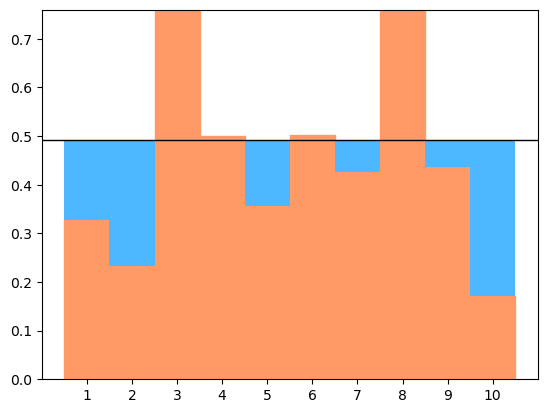

In [223]:
visualize_water(alpha,x,horizontal_line)

此处与$fill\_water$函数中的关于 $track$ 的if 判断语句相对应，可以将最终的 $x^*$ 以及每一次iteration之后的targets和errors输出，便于在代码出现问题之后debug

同时，此处可查看迭代的次数

In [224]:
x,targets,errors = fill_water(alpha = alpha,total_water=total_water,precision=precision,track = True)
print(x)
print(targets)
print(errors)

print('iteration:',len(errors))

[[0.16404628]
 [0.25957092]
 [0.        ]
 [0.        ]
 [0.13654939]
 [0.        ]
 [0.06477001]
 [0.        ]
 [0.05521038]
 [0.31985361]]
[np.float64(11.326404387036801), np.float64(5.116467632047577), np.float64(9.54032359175143), np.float64(7.691892391146476), np.float64(8.784728359693224), np.float64(9.171920323766575), np.float64(8.981667165402543), np.float64(8.88494917322288), np.float64(8.933443251010033), np.float64(8.909230171599093), np.float64(8.921345177419006), np.float64(8.927396327784502), np.float64(8.930420317420612), np.float64(8.931931916175058), np.float64(8.93268761657672), np.float64(8.932309774622654), np.float64(8.932498697661288), np.float64(8.932593157634393), np.float64(8.932545927776689), np.float64(8.932569542737752), np.float64(8.932581350194125)]
[np.float64(0.7003690142193949), np.float64(1.5486101746308378), np.float64(0.20005103890057518), np.float64(0.4484053503487848), np.float64(0.05083019166170044), np.float64(0.08046355800035276), np.float64(0.

此处定义 $visualize\_targets\_and\_errors$函数，对在迭代过程中的targets和errors的变化进行可视化呈现，以观察实验效果

In [225]:
def visualize_targets_and_errors(targets,errors):
    x = range(len(targets))
    plt.plot(x,targets,label = 'targets')
    plt.plot(x,errors,label = 'errors')

    plt.legend(loc = 'best')

    plt.show()

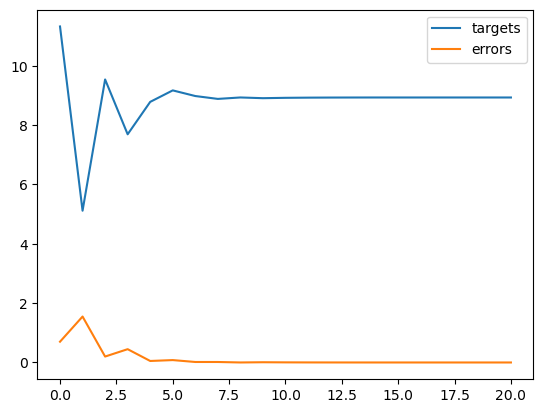

In [226]:
visualize_targets_and_errors(targets,errors)

⼀顿操作之后，我们很自然地想确认自己的结果是不是正确的，但对于该问题，由于$\alpha$生成的随机性，“标准答案”并不好寻找，我们就可以通过判断我们的实现的算法是否⽐随机⽣成的解要好，以此来判断我们的解的正确性

此处我们定义了一个 $monkey_search$函数以生成随机解，并将其可视化呈现。其中橙线是我们得到的optimal solution of $-\sum_{i = 1}^{n} \log (\alpha_i + x_i)$,蓝点即是每一只“猴子”确定的随机解

In [227]:
def monkey_search(alpha):
    while True:
        monkey_solutions = np.random.dirichlet(np.ones(10),size = 1).reshape(-1,1)
        if np.less(monkey_solutions,0).any():
            continue
        return monkey_solutions
    
def visualize_monkey_search(alpha,monkey_amount,optimal):
    monkey_solutions = [calculate_target(alpha,monkey_search(alpha))\
                        for _ in range(monkey_amount)]
    plt.scatter(range(monkey_amount),monkey_solutions)
    plt.axhline(y = optimal,linewidth = 1,color = 'r')

    plt.show()

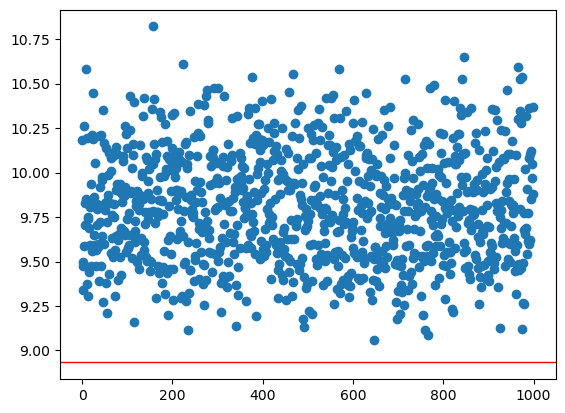

In [228]:
optimal_line= targets[len(targets)-1]
visualize_monkey_search(alpha,1000,optimal_line)